In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 112.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=b35f37f3e7d950a49c851cf72d2cd74adc8b92c3792c81a6290d14f369dd63e6
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


Initial state of qubit 0:


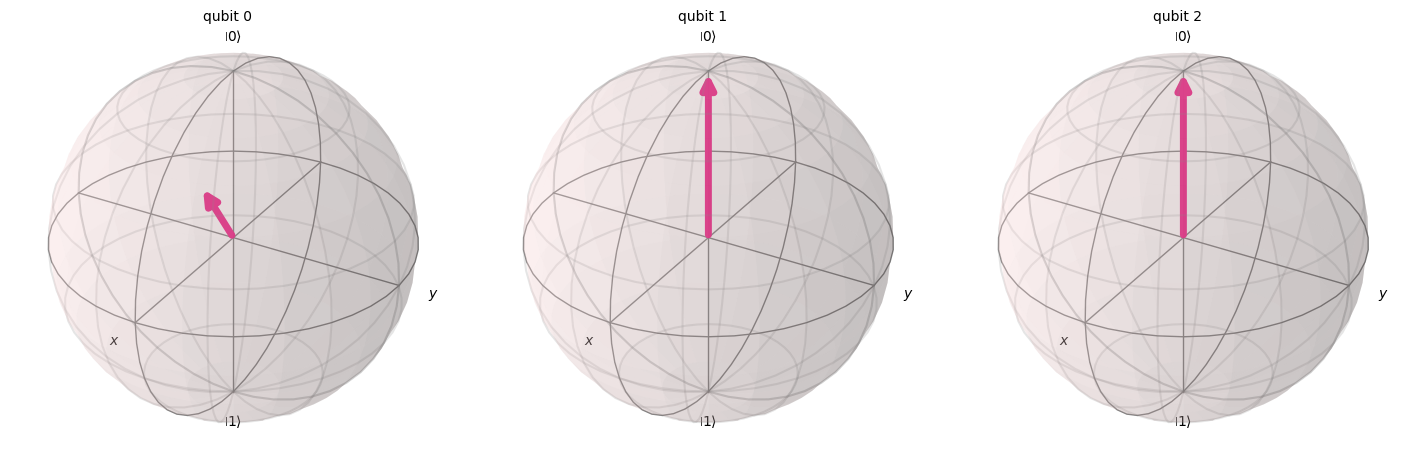

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


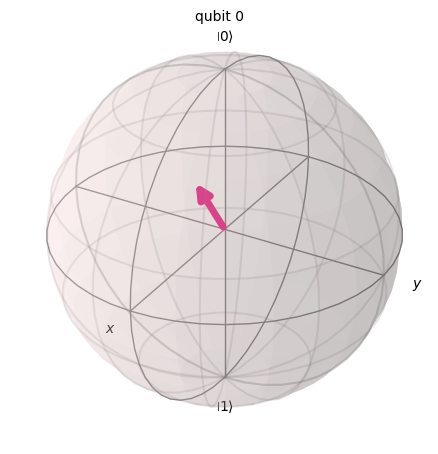

In [2]:
# Quantum Teleportation (Coherent version) – Qiskit 2.x compatible
# Works on modern qiskit-aer simulators

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Build the teleportation circuit
qc = QuantumCircuit(3)

# Prepare arbitrary state |ψ⟩ on qubit 0
theta, phi = 0.8, 0.3
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part (but coherent)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector explicitly (Qiskit 2.x requires this)
qc.save_statevector()

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres (fixed)
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)

display(plot_bloch_multivector(bob_sv))

Task 1: Custom State Teleportation

Theta = 0.79, Phi = 1.57


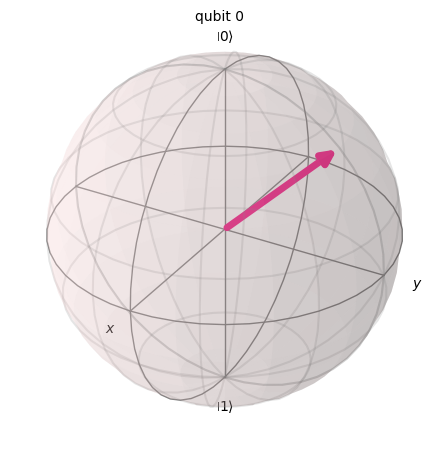

Theta = 1.57, Phi = 0.79


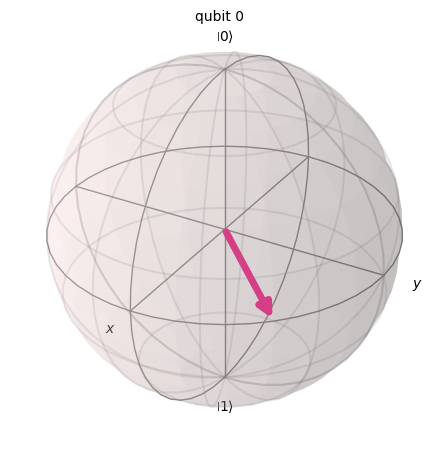

Theta = 1.05, Phi = 0.52


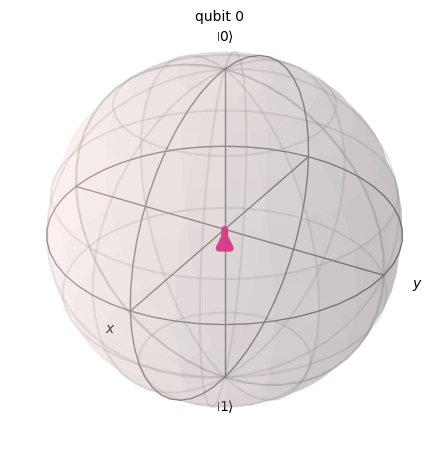

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# Function to prepare and visualize custom state
def teleport_custom_state(theta, phi):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv = Statevector.from_instruction(qc)
    print(f"Theta = {theta:.2f}, Phi = {phi:.2f}")
    display(plot_bloch_multivector(sv))

# Try different theta, phi combinations
angles = [(np.pi/4, np.pi/2), (np.pi/2, np.pi/4), (np.pi/3, np.pi/6)]
for theta, phi in angles:
    teleport_custom_state(theta, phi)


Task 2: Add Classical Measurement

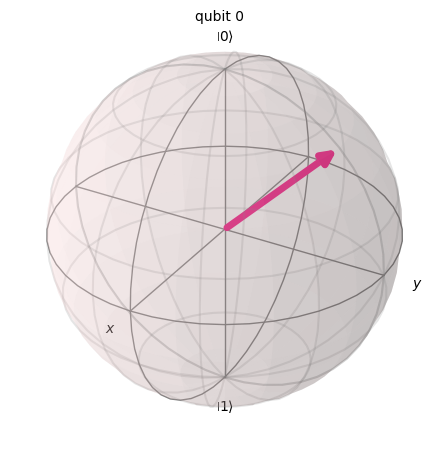

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np

qc = QuantumCircuit(3, 2)
theta, phi = np.pi/4, np.pi/2
qc.ry(theta, 0)
qc.rz(phi, 0)

qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])

with qc.if_test((qc.clbits[1], 1)):  # if bit 1 == 1 → apply X
    qc.x(2)

with qc.if_test((qc.clbits[0], 1)):  # if bit 0 == 1 → apply Z
    qc.z(2)
qc.save_statevector()
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

sv_final = Statevector(result.data(0)["statevector"])
rho_bob = partial_trace(sv_final, [0, 1])
display(plot_bloch_multivector(rho_bob))


Task 3: Fidelity Analysis

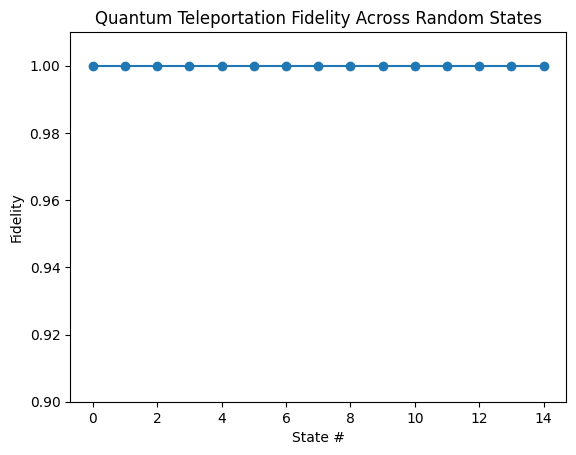

Average Fidelity: 1.0000000000000002


In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np
import matplotlib.pyplot as plt

def teleportation_fidelity(theta, phi):
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_init = Statevector.from_instruction(qc)

    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(1, 2)
    qc.cz(0, 2)
    qc.save_statevector()

    sim = AerSimulator()
    result = sim.run(transpile(qc, sim)).result()
    sv_final = Statevector(result.data(0)['statevector'])
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_init, [1, 2])
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob = eigvecs_b[:, np.argmax(eigvals_b)]
    init = eigvecs_i[:, np.argmax(eigvals_i)]
    return np.abs(np.vdot(init, bob))**2

# Run multiple random states
thetas = np.random.uniform(0, np.pi, 15)
phis = np.random.uniform(0, 2*np.pi, 15)
fidelities = [teleportation_fidelity(t, p) for t, p in zip(thetas, phis)]

plt.plot(range(len(fidelities)), fidelities, marker='o')
plt.title("Quantum Teleportation Fidelity Across Random States")
plt.xlabel("State #")
plt.ylabel("Fidelity")
plt.ylim(0.9, 1.01)
plt.show()

print("Average Fidelity:", np.mean(fidelities))


Task 4: Step-by-Step Visualization

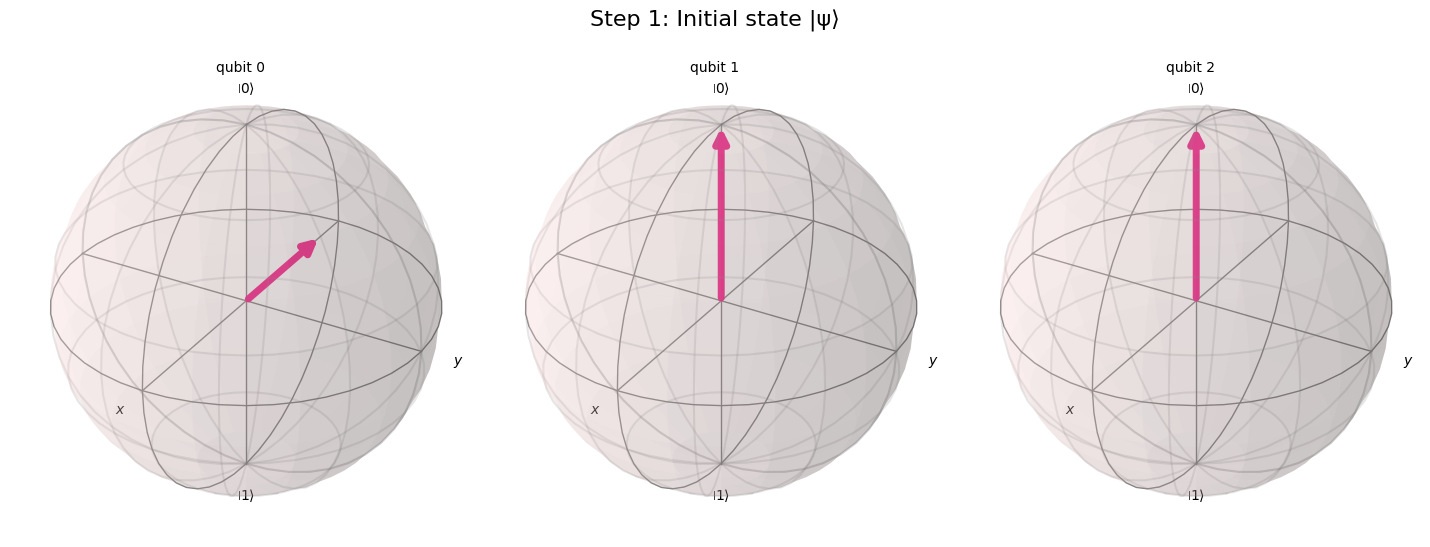

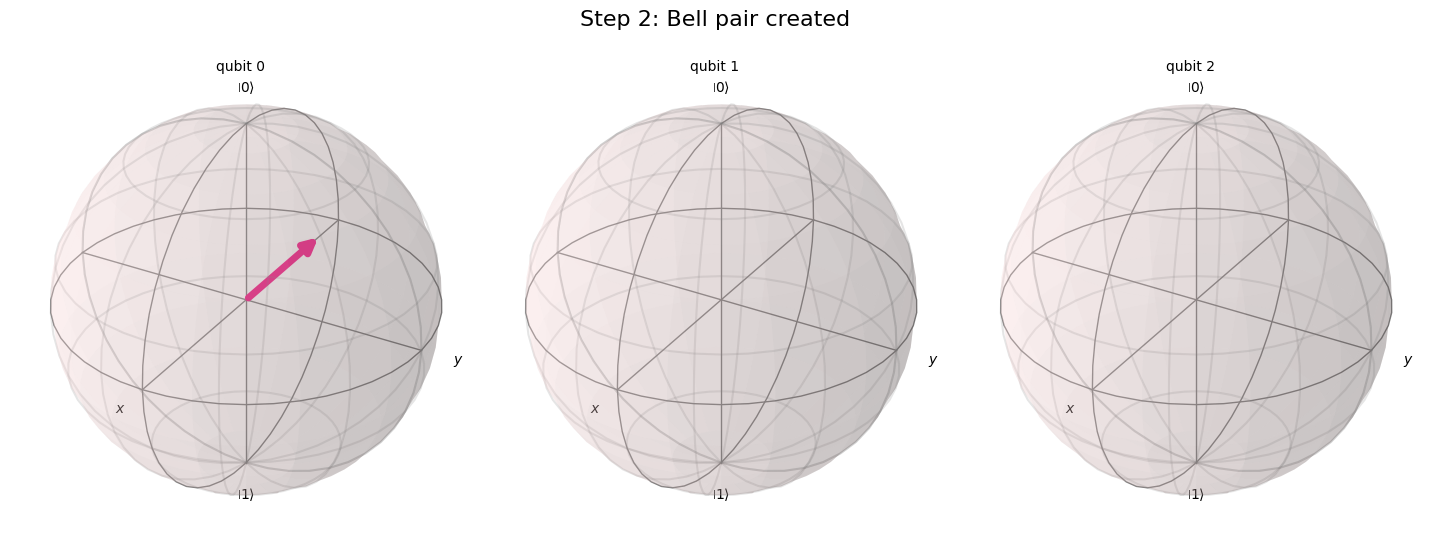

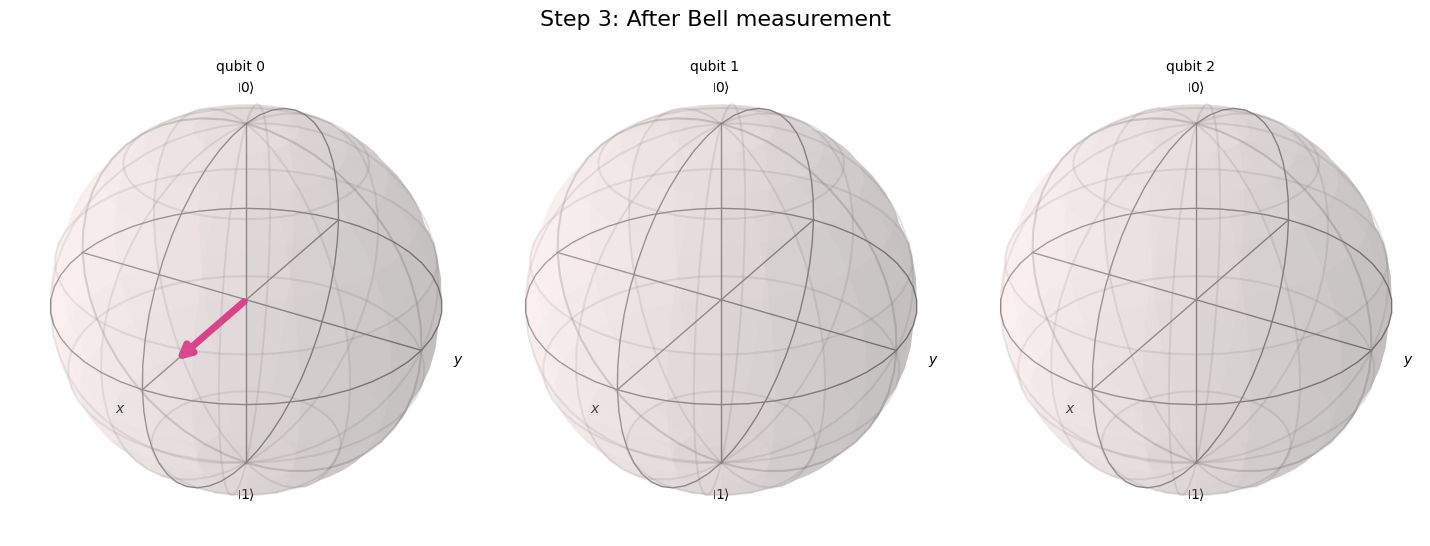

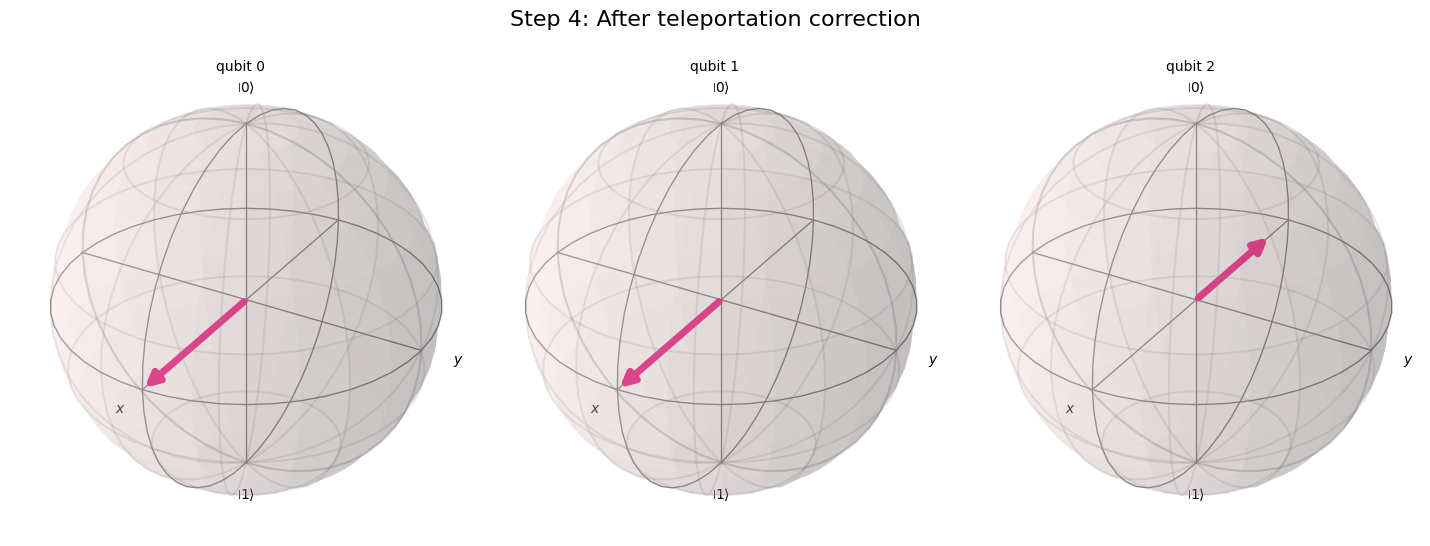

In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from IPython.display import display

qc = QuantumCircuit(3)
theta, phi = np.pi/4, np.pi/3

# Step 1: Prepare initial state
qc.ry(theta, 0)
qc.rz(phi, 0)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 1: Initial state |ψ⟩"))

# Step 2: Create Bell pair
qc.h(1)
qc.cx(1, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 2: Bell pair created"))

# Step 3: Bell measurement (coherent)
qc.cx(0, 1)
qc.h(0)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 3: After Bell measurement"))

# Step 4: Coherent correction
qc.cx(1, 2)
qc.cz(0, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 4: After teleportation correction"))


Task 5: Introduce Noise

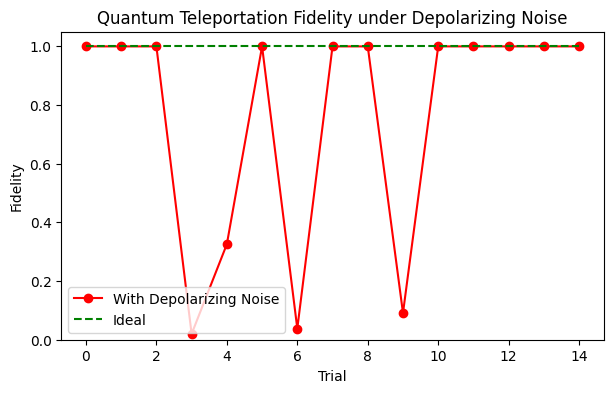

Average noisy fidelity = 0.7650


In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ["ry", "rz", "h"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ["cx", "cz"])

def noisy_fidelity(theta, phi):
    qc = QuantumCircuit(3)

    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_init = Statevector.from_instruction(qc)

    qc.h(1)
    qc.cx(1, 2)

    qc.cx(0, 1)
    qc.h(0)

    qc.cx(1, 2)
    qc.cz(0, 2)

    qc.save_statevector()

    sim = AerSimulator(noise_model=noise_model)
    result = sim.run(transpile(qc, sim)).result()
    sv_final = Statevector(result.data(0)["statevector"])

    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_init, [1, 2])

    return state_fidelity(rho_init, rho_bob)


N = 15
thetas = np.random.uniform(0, np.pi, N)
phis = np.random.uniform(0, 2*np.pi, N)
f_noisy = [noisy_fidelity(t, p) for t, p in zip(thetas, phis)]
f_ideal = [1.0] * N

plt.figure(figsize=(7, 4))
plt.plot(f_noisy, "ro-", label="With Depolarizing Noise")
plt.plot(f_ideal, "g--", label="Ideal")
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Quantum Teleportation Fidelity under Depolarizing Noise")
plt.legend()
plt.ylim([0, 1.05])
plt.show()

print(f"Average noisy fidelity = {np.mean(f_noisy):.4f}")
